In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/e/ocr_python'
img_file_path = work_dir + '/snack.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

In [ ]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

## 프로젝트 - 다양한 OCR 모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. __용도에 맞게 적절한 것을 선택하는 것__도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

### Step1. 검증용 데이터셋 준비
---
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

In [5]:
import os
from os import listdir
from os.path import isfile, join

# keras
import matplotlib.pyplot as plt
import keras_ocr
import matplotlib.image as img
%matplotlib inline

# tesseract
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [6]:
# 이미지 파일들의 리스트를 한 번에 얻는 코드
# 출처: stack overflow 'https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory' 참고)
work_dir= os.getenv('HOME')+'/aiffel/e/ocr_python/img_dir'
img_list = [join(work_dir,f) for f in listdir(work_dir) if isfile(join(work_dir, f))]

img_list.sort()
img_list

['/home/aiffel/aiffel/e/ocr_python/img_dir/test00.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test01.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test02.jpeg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test03.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test04.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test05.jpeg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test06.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test07.png',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test08.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test09.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test10.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test11.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test12.jpeg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test12.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test13.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test14.jpg',
 '/home/aiffel/aiffel/e/ocr_python/img_dir/test15.jpg']

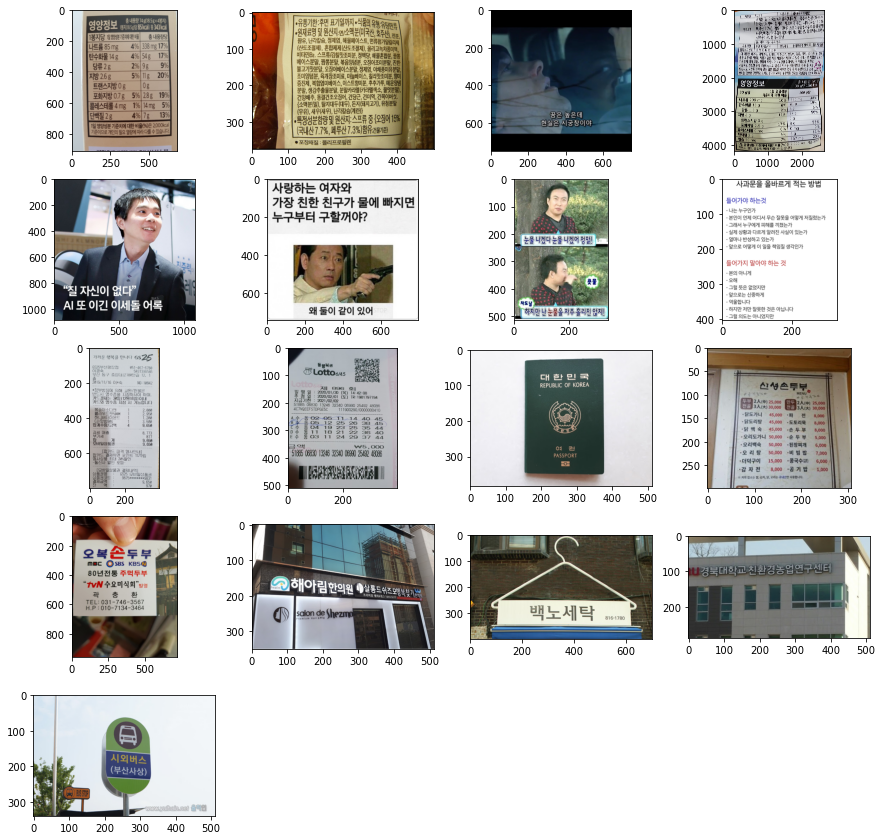

In [8]:
plt.figure(figsize=(15,15))

for idx, im in enumerate(img_list):
    plt.subplot(5,4, idx+1)
    im = img.imread(im)
    plt.imshow(im)

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### Google OCR API

In [12]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('================ bounds: {} ==============='.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
for im in img_list:
    detect_text(im)

Texts:

"영양정보
총 내용량 74g(18.5gx4봉지)
병지(35g당 85kcall 총3kcal
총 내용량당
4% 338 mg 17%
4% 54 g 17%
9%
1봉지당 1일영향성분 기준차에 대한 비율
|나트륨 85 mg
탄수화물 14 g
당류 2g
X 2.6g
트랜스지방 0 g
포화지방 0.7 g
2% 9g
5%| 11g 20%
0g
5% 2.8 g 19%
콜레스테롤 4 mg 1%| 14 mg 5%
13%
단백질 28
4% 7g
1일 영양성분 기준치에 대한 비율(%)은 2000kcal
기준이므로 개인의 필요 열량에 따라 다를 수 있습니다.
"

"영양"

"정보"

"총"

"내용량"

"74g"

"("

"18.5gx4"

"봉지"

")"

"병지"

"("

"35g"

"당"

"85kcall"

"총"

"3kcal"

"총"

"내용량"

"당"

"4%"

"338"

"mg"

"17%"

"4%"

"54"

"g"

"17%"

"9%"

"1"

"봉지"

"당"

"1"

"일"

"영향"

"성분"

"기준"

"차"

"에"

"대한"

"비율"

"|"

"나트륨"

"85"

"mg"

"탄수화물"

"14"

"g"

"당류"

"2g"

"X"

"2.6g"

"트랜스"

"지방"

"0"

"g"

"포화"

"지방"

"0.7"

"g"

"2%"

"9g"

"5%|"

"11g"

"20%"

"0g"

"5%"

"2.8"

"g"

"19%"

"콜레스테롤"

"4"

"mg"

"1"

"%"

"|"

"14"

"mg"

"5"

"%"

"13%"

"단백질"

"28"

"4%"

"7g"

"1"

"일"

"영양"

"성분"

"기준치"

"에"

"대한"

"비율"

"("

"%"

")"

"은"

"2000kcal"

"기준"

"이므로"

"개인"

"의"

"필요"

"열량"

"에"

"따라"

"다를"

"수"

"있습니다"

"."
================ bounds: (

Texts:

"BLotto6/45
Lotto
제 896 회
발행 일 : 2020/01/30 (목) 14:42:08
추첨일 : 2020/02/01 (토) TR: 1981797194
지급기한 : 2021/02/02
51885 06830 13246 32340 06990 25492 48086
4C7VQEEFSTDPGE5C
111900290/0000000410
02-05 11 14 4 O 45
05 12 25 26 38 45
04 19 23 25 35 44
11 18 21 22 36 40
03 11 24 29 37 44
W5,000
금액
51885 06830 13246 32340 06990 25492 48086
www.dhlottery
동동도도o도으
"

"BLotto6/45"

"Lotto"

"제"

"896"

"회"

"발행"

"일"

":"

"2020/01/30"

"("

"목"

")"

"14:42:08"

"추첨일"

":"

"2020/02/01"

"("

"토"

")"

"TR"

":"

"1981797194"

"지급기"

"한"

":"

"2021/02/02"

"51885"

"06830"

"13246"

"32340"

"06990"

"25492"

"48086"

"4C7VQEEFSTDPGE5C"

"111900290/0000000410"

"02-05"

"11"

"14"

"4"

"O"

"45"

"05"

"12"

"25"

"26"

"38"

"45"

"04"

"19"

"23"

"25"

"35"

"44"

"11"

"18"

"21"

"22"

"36"

"40"

"03"

"11"

"24"

"29"

"37"

"44"

"W5,000"

"금액"

"51885"

"06830"

"13246"

"32340"

"06990"

"25492"

"48086"

"www.dhlottery"

"동동"

"도"

"도"

"o"

"도으"
================ bounds: (58,

### keras-ocr

In [14]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
# url 대신
images_keras_ocr = [ keras_ocr.tools.read(img) for img in img_list]

prediction_groups = [pipeline.recognize([img]) for img in img_list]


In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/e/ocr_python'
img_file_path = work_dir + '/snack.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

### Step3. 테스트 결과 정리
---
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### Step4. 결과 분석과 결론 제시
---
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

## 평가문항
상세기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.